<a href="https://colab.research.google.com/github/zhus-dika/predicting_models_NBA_games/blob/explore_data/notebooks/salary_predictionML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import r2_score, mean_squared_error

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

from tqdm import tqdm
np.random.seed(42)


# Data Prep & EDA

## Загрузка и предобработка данных

In [ ]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
files = [f'{i}_advanced_plus_totals.csv' for i in range(2011, 2022)]
for idx, file in enumerate(files):
    if idx == 0:
        df = pd.read_csv(f'{file}')
        df['year'] = int(file[:4])
    else:
        df_loc = pd.read_csv(f'{file}')
        df_loc['year'] = int(file[:4])
        df = pd.concat([df, df_loc])
df = df.drop(['Salary'], axis=1)
df.sample(10)

Player Pos  Age   Tm   G  GS    MP   FG  FGA    FG%  ...  STL%  \
79       Baron Davis  PG   32  NYK  29  14   595   68  184  0.370  ...   2.9   
38      DeJuan Blair  PF   25  WAS  29   0   180   26   57  0.456  ...   2.0   
2       Cole Aldrich   C   24  TOT  45   0   388   44   80  0.550  ...   0.7   
316    Yuta Watanabe  SF   24  MEM  15   0   174   15   51  0.294  ...   1.1   
257    Dirk Nowitzki  PF   38  DAL  54  54  1424  296  678  0.437  ...   1.1   
286  Thomas Robinson  PF   22  POR  70   0   873  141  293  0.481  ...   1.3   
28    Jerryd Bayless  PG   26  MIL  77   4  1717  220  516  0.426  ...   1.8   
97     Toney Douglas  SG   28  NOP  12   0   177   19   51  0.373  ...   3.3   
73   Jordan Crawford  SG   23  WAS  64  32  1753  349  872  0.400  ...   1.7   
240    Quincy Miller  PF   22  TOT  10   0   119    9   38  0.237  ...   3.0   

     TOV%  TRB%    TS%  USG%  VORP   WS  WS/48   SalaryAdj  year  
79   28.1   5.4  0.457  20.4   0.0  0.2  0.014  19174902.0  2012  
38   17.9  17.5  0.469  18.3  -0.3  0.1  0.033   2483351.0  2015  
2    20.6  17.7  0.563  12.7  -0.1  0.6  0.070   1122146.0  2013  
316   9.8  10.0  0.352  15.8  -0.3 -0.2 -0.065     92045.0  2019  
257   6.6  14.4  0.529  25.8   1.0  2.5  0.084   6048274.0  2017  
286  14.5  18.9  0.502  19.7  -0.3  1.6  0.090   4572982.0  2014  
28   18.8   7.0  0.519  18.6   0.0  2.4  0.066   3725027.0  2015  
97   15.0   7.1  0.450  17.2   0.0  0.2  0.046   3689723.0  2015  
73   12.8   5.4  0.488  28.1   0.1  1.1  0.029   1547782.0  2012  
240  10.5   9.4  0.338  17.8  -0.1 -0.1 -0.030     62083.0  2015  

[10 rows x 51 columns]

In [ ]:
df.shape

(3976, 51)

In [ ]:
df.describe()

Age            G           GS           MP           FG  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000   
mean     25.980634    54.824698    27.824447  1304.657193   210.537475   
std       4.080125    22.091945    28.442512   804.503983   165.912698   
min      19.000000     1.000000     0.000000     0.000000     0.000000   
25%      23.000000    40.000000     2.000000   602.750000    74.000000   
50%      25.000000    61.000000    16.000000  1295.000000   181.000000   
75%      29.000000    73.000000    55.000000  1962.250000   307.000000   
max      42.000000    83.000000    82.000000  3227.000000   857.000000   

               FGA          FG%           3P          3PA          3P%  ...  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000  ...   
mean    459.633551     0.449906    48.782696   135.915996     0.277080  ...   
std     353.425880     0.085074    54.606877   142.808977     0.155784  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     169.000000     0.409000     3.000000    11.000000     0.220750  ...   
50%     392.000000     0.444000    31.000000    96.000000     0.331000  ...   
75%     671.000000     0.487000    79.000000   220.250000     0.374000  ...   
max    1941.000000     1.000000   402.000000  1028.000000     1.000000  ...   

              STL%         TOV%         TRB%          TS%         USG%  \
count  3976.000000  3976.000000  3976.000000  3976.000000  3976.000000   
mean      1.582721    13.073969    10.131916     0.533724    18.864336   
std       0.801515     5.158837     4.759968     0.077721     5.303849   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.100000    10.100000     6.300000     0.502000    15.100000   
50%       1.500000    12.500000     9.100000     0.539000    18.200000   
75%       1.900000    15.300000    13.100000     0.574000    22.100000   
max      16.200000   100.000000    55.900000     1.000000    43.900000   

              VORP           WS        WS/48     SalaryAdj         year  
count  3976.000000  3976.000000  3976.000000  3.976000e+03  3976.000000  
mean      0.708350     2.823516     0.086314  7.943507e+06  2016.144869  
std       1.332865     2.848407     0.072712  8.831567e+06     3.177300  
min      -2.000000    -2.100000    -0.899000  2.092400e+04  2011.000000  
25%      -0.100000     0.600000     0.050000  1.830929e+06  2013.000000  
50%       0.300000     2.100000     0.089000  4.294796e+06  2016.000000  
75%       1.100000     4.200000     0.126000  1.088712e+07  2019.000000  
max       9.900000    19.300000     0.475000  4.992861e+07  2021.000000  

[8 rows x 48 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3976 entries, 0 to 411
Data columns (total 51 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     3976 non-null   object 
 1   Pos        3976 non-null   object 
 2   Age        3976 non-null   int64  
 3   Tm         3976 non-null   object 
 4   G          3976 non-null   int64  
 5   GS         3976 non-null   int64  
 6   MP         3976 non-null   int64  
 7   FG         3976 non-null   int64  
 8   FGA        3976 non-null   int64  
 9   FG%        3976 non-null   float64
 10  3P         3976 non-null   int64  
 11  3PA        3976 non-null   int64  
 12  3P%        3976 non-null   float64
 13  2P         3976 non-null   int64  
 14  2PA        3976 non-null   int64  
 15  2P%        3976 non-null   float64
 16  eFG%       3976 non-null   float64
 17  FT         3976 non-null   int64  
 18  FTA        3976 non-null   int64  
 19  FT%        3976 non-null   float64
 20  ORB      

In [ ]:
df.isna().sum()

Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
3PAr         0
AST%         0
BLK%         0
BPM          0
DBPM         0
DRB%         0
DWS          0
FTr          0
OBPM         0
ORB%         0
OWS          0
PER          0
STL%         0
TOV%         0
TRB%         0
TS%          0
USG%         0
VORP         0
WS           0
WS/48        0
SalaryAdj    0
year         0
dtype: int64

## EDA

🐪 Создадим переменные с перечислениями столбцов разного типа

In [ ]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
continuous_cols_full = ['year','Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']
continuous_cols = ['year','Age', 'G', 'GS', 'MP', 'FG%', '3P', '3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'USG%', 'VORP', 'WS/48']
categorical_cols = [ 'Pos']

🐘 Уберем признаки, которые сильно коррелируют с другими

In [ ]:
df_train = df.drop(['Player', 'Tm', 'FGA', '3PA', '2PA', '2P', 'FTA', 'TS%', 'TRB%', 'WS', 'OBPM', 'TRB', 'FG', 'FT'], axis=1)

In [ ]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train[continuous_cols] = scaler.fit_transform(df_train[continuous_cols])
df_train.sample(7)

Pos       Age         G        GS        MP       FG%        3P  \
238    PF -1.220860 -0.127877 -0.415784 -0.641044 -0.974639 -0.344005   
67   SF-C  1.720596 -1.395467 -0.978393 -1.261379 -0.833568 -0.746936   
252    PF -0.975738 -2.391430 -0.978393 -1.610707 -5.289064 -0.893456   
382    PF -0.240374 -0.716401 -0.345458 -0.587588 -1.209758 -0.435580   
283    SF  1.965718  0.143749 -0.415784  0.114797 -0.116456 -0.325690   
148    SG  0.004747 -0.308961 -0.908067 -1.040097  0.588899 -0.728621   
41     SF  0.985232  1.230255 -0.591599 -0.029410 -0.328063 -0.398950   

          3P%       2P%      eFG%  ...      ORB%       OWS       PER  \
238  0.269125 -1.019874 -0.913646  ... -0.060054 -1.076439 -0.970535   
67  -0.225212  0.274670 -0.754839  ... -0.183402 -0.730599 -0.874443   
252 -1.778845 -5.281082 -6.117642  ... -1.268858 -0.730599 -3.065331   
382 -0.122493  0.328609 -0.840351  ...  0.334657 -0.681193 -1.181936   
283  1.193601 -0.577571 -0.266201  ... -0.257410 -0.088324 -0.317112   
148 -0.026193  0.986669  0.430108  ...  0.112632 -0.532976 -0.105710   
41  -0.308672  0.350185 -0.486088  ... -0.602783 -0.730599 -0.874443   

         STL%      TOV%      USG%      VORP     WS/48  SalaryAdj      year  
238 -0.227999  0.295846 -0.219554 -0.831659 -1.159707   495286.0 -0.675145  
67  -0.352778  0.722353 -0.766396 -0.606552 -0.568261  7033934.0  1.213488  
252 -1.974911 -2.534605 -3.557173 -0.531516 -0.196888   261163.0  0.583944  
382 -0.103219 -0.169433 -1.878935 -0.606552 -0.499488  2298793.0  1.213488  
283 -0.602337 -1.080606 -0.728683 -0.156337 -0.004324  1861504.0 -0.360373  
148  1.144575  0.121366 -0.672113 -0.381445  0.367049  1744762.0  1.213488  
41   0.895016 -0.072500 -0.860679 -0.681588 -0.568261  9804995.0  0.269171  

[7 rows x 37 columns]

🦓 Закодируем категориальные фичи с помощью OHE

In [ ]:
df_train_cat = pd.get_dummies(df_train, columns=categorical_cols)
df_train_cat.sample(7)

Age         G        GS        MP       FG%        3P       3P%  \
89  -1.465981  0.370105  0.252314  0.250301 -0.539670  0.315335  0.140726   
376  1.230354  0.098478  1.025902  0.925336  0.259733  0.113870 -0.122493   
286 -0.975738  0.189020 -0.626762 -0.402357 -0.586693 -0.289060  0.301225   
300  0.494990  0.777544 -0.978393 -0.587588 -0.210504 -0.453895  0.705683   
84   1.720596  0.958628 -0.837740  0.101122  0.906309 -0.435580  0.545184   
314 -1.220860 -2.436701 -0.978393 -1.619409 -5.289064 -0.893456 -1.778845   
341  0.004747  1.049170  1.764326  1.903701  0.012859  0.736581  0.320485   

          2P%      eFG%       FT%  ...  Pos_PG  Pos_PG-SG  Pos_SF  Pos_SF-C  \
89  -0.199996 -0.473872 -1.611444  ...       0          0       0         0   
376  0.263882 -0.095178  0.239445  ...       1          0       0         0   
286 -0.502056 -0.522736  0.387024  ...       0          0       1         0   
300 -0.545208 -0.522736  0.620691  ...       0          0       0         0   
84   0.803276  0.723291  0.079568  ...       0          0       0         0   
314 -5.281082 -6.117642 -4.452342  ...       0          0       0         0   
341 -0.102905 -0.229553  0.473112  ...       1          0       0         0   

     Pos_SF-PF  Pos_SF-SG  Pos_SG  Pos_SG-PF  Pos_SG-PG  Pos_SG-SF  
89           0          0       1          0          0          0  
376          0          0       0          0          0          0  
286          0          0       0          0          0          0  
300          0          0       0          0          0          0  
84           0          0       0          0          0          0  
314          0          0       0          0          0          0  
341          0          0       0          0          0          0  

[7 rows x 51 columns]

🐕 Разобьем выборку на трейн и вал

In [ ]:
#☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️☁️
X_train, X_val, y_train, y_val = train_test_split(df_train_cat.drop(['SalaryAdj'], axis=1), df_train_cat.SalaryAdj, test_size=0.3, random_state=42)

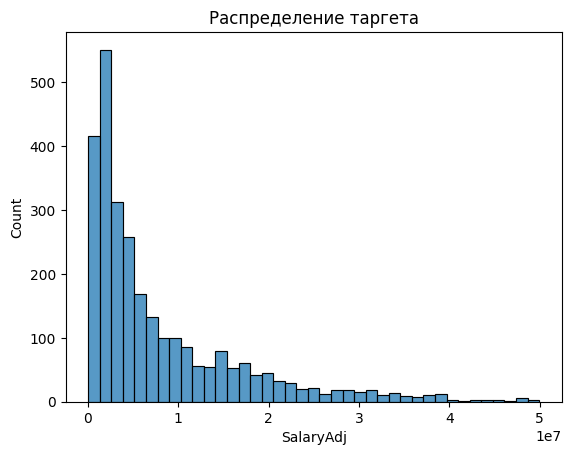

In [ ]:
# visualize y_train
sns.histplot(y_train).set_title('Распределение таргета');

🦍 Отобразим тепловую карту фичей

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


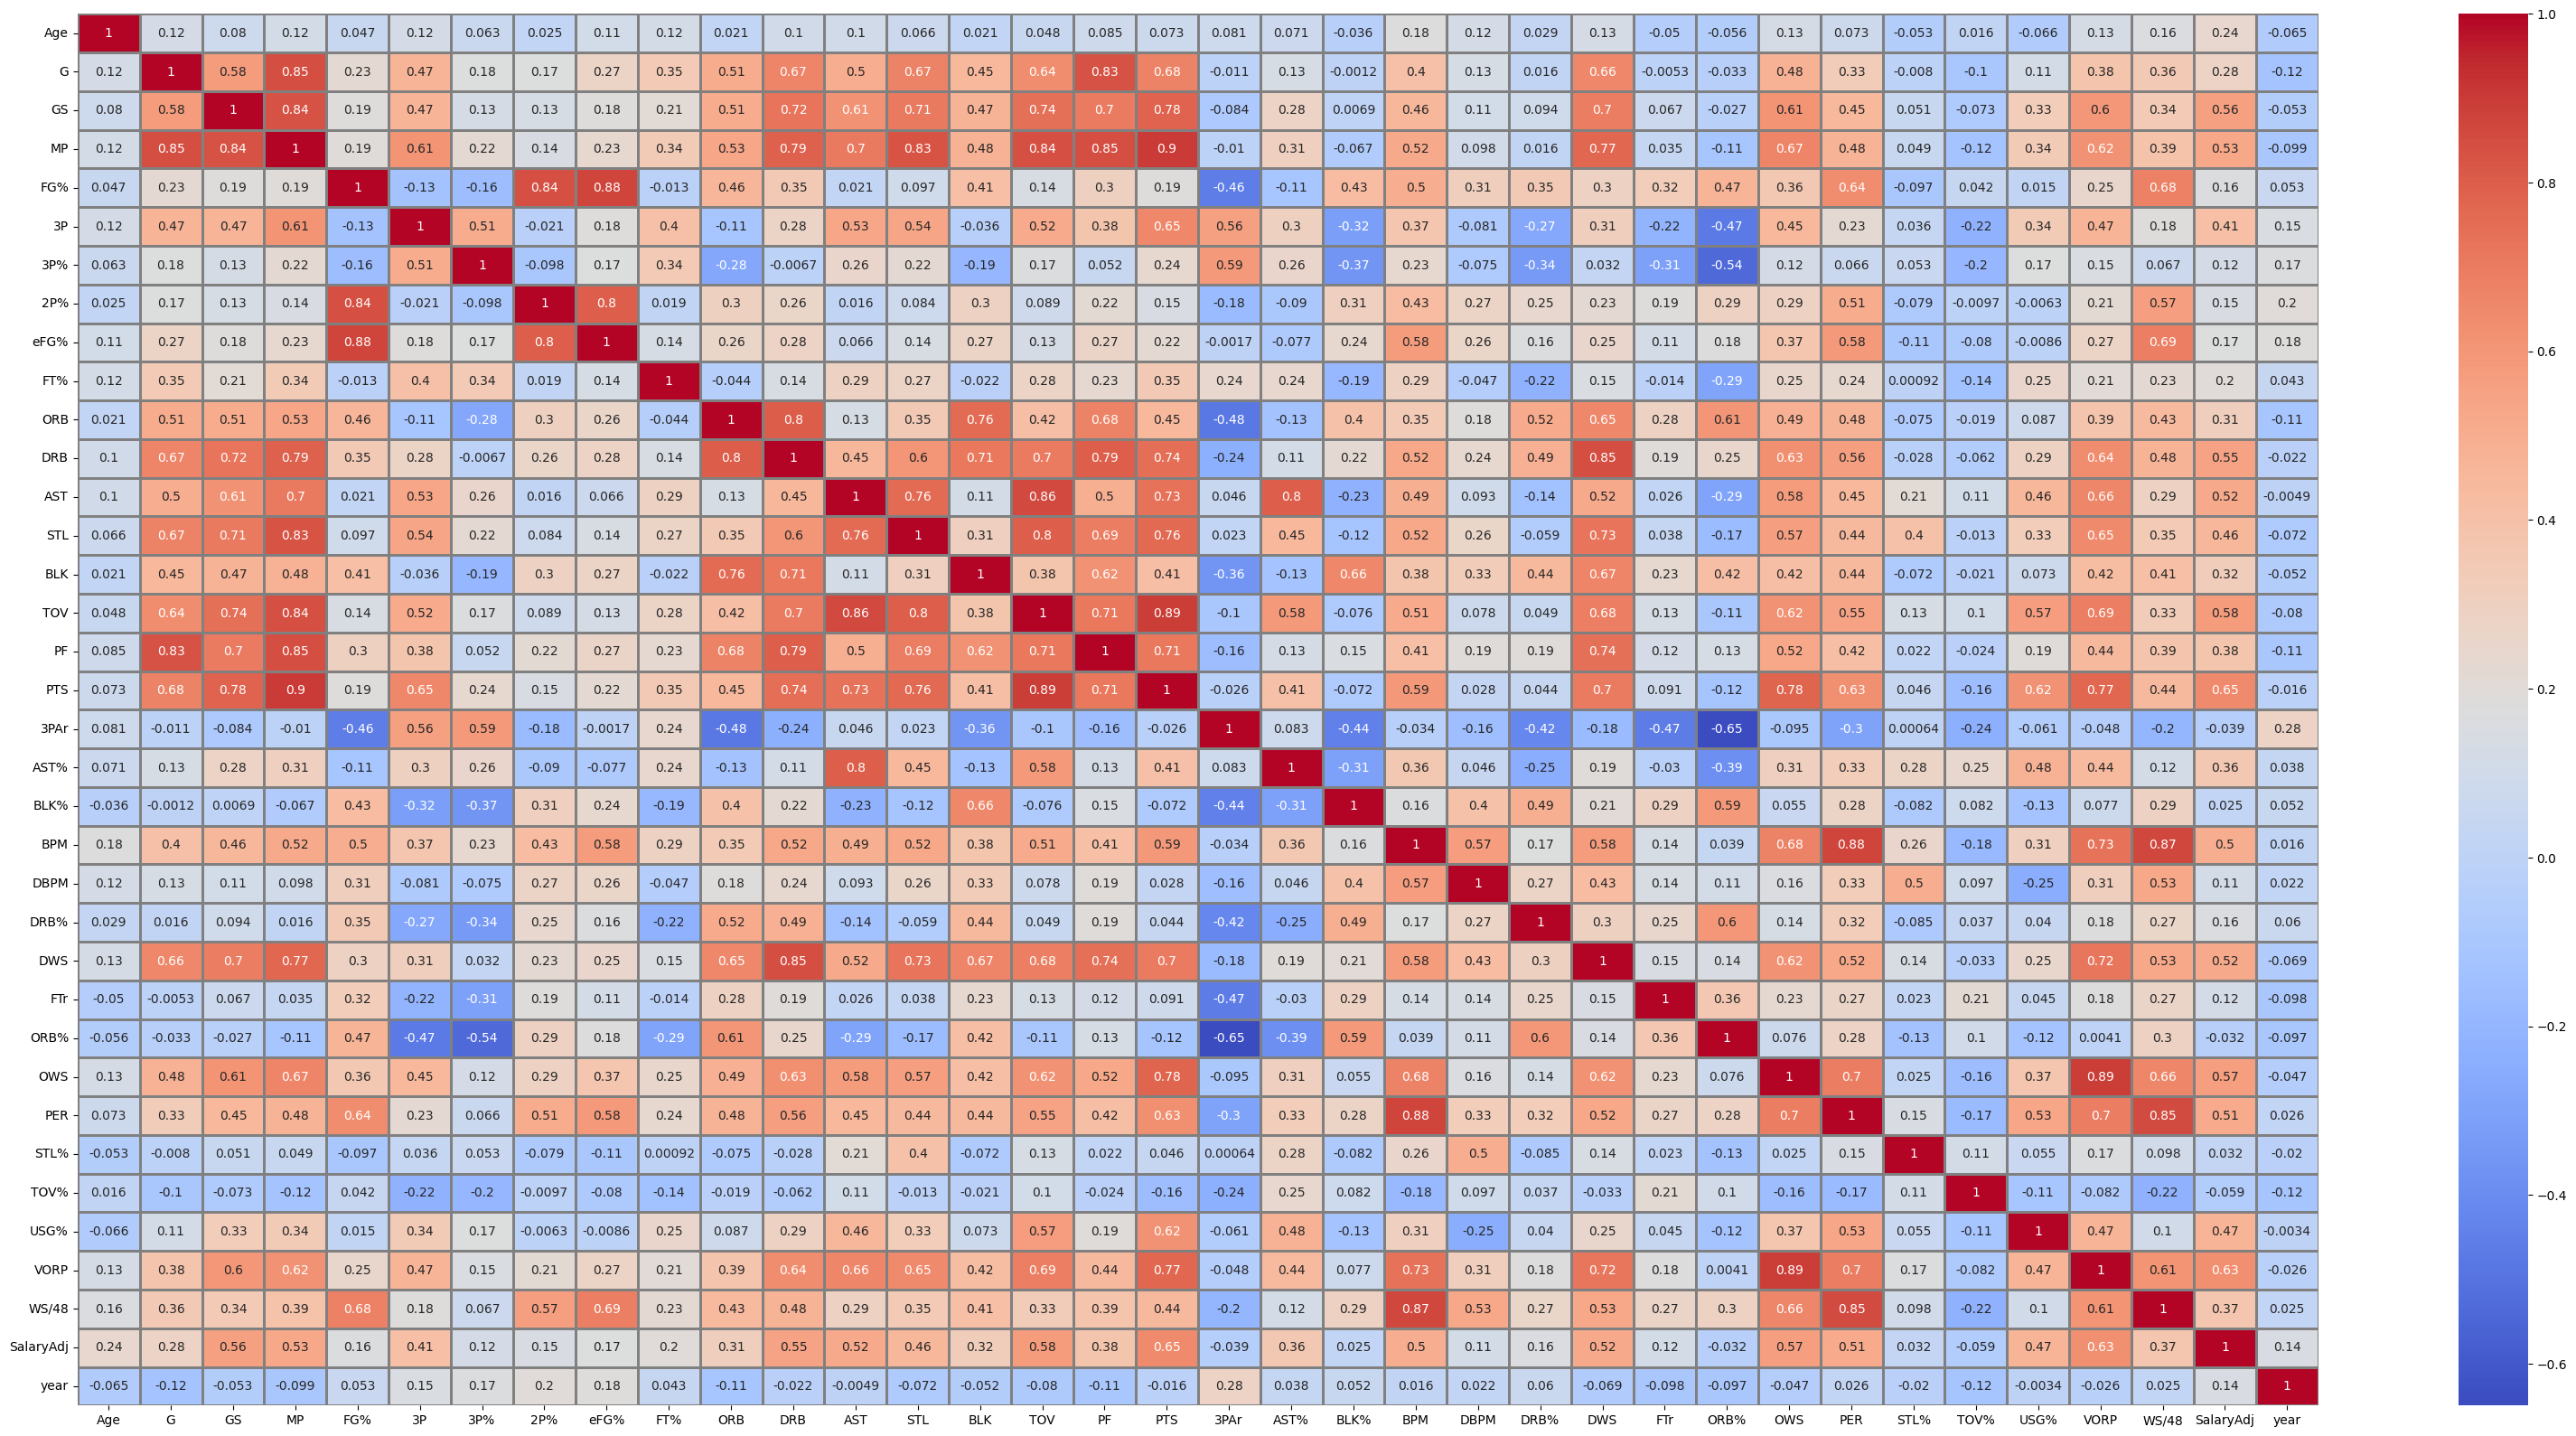

In [ ]:
plt.figure(figsize = (40,20))
sns.heatmap(df_train.corr(), annot = True, cmap= 'coolwarm', linewidths=1, linecolor='grey');

🐩 Попробуем модель Random Forest с параметрами по умолчанию

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rand_forest = RandomForestRegressor(random_state=123)
rand_forest.fit(X_train, y_train)
y_predicted_val = rand_forest.predict(X_val)
print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

mse for val data: 24092914196453.383
r2 score for val data: 0.686481053862693


In [ ]:
df_train_cat.shape

(3976, 51)

🐈‍ Попробуем подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`

In [ ]:
# https://www.kaggle.com/code/funxexcel/p3-random-forest-tuning-randomizedsearchcv/notebook
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from scipy.stats import uniform


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
#[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#uniform(loc=10, scale=80)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
clf = RandomizedSearchCV(rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  37.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  38.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=  36.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=  27.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=  28.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=466; total time=  26.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  14.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  15.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  14.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  18.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  18.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  18.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   3.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   3.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.7s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=   7.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=   7.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=   7.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  35.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  37.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  37.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=   4.9s
[CV] END bootstrap=True, max_depth=50, max_feat

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=555; total time=  32.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=555; total time=  34.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=555; total time=  30.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   6.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  33.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  23.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  25.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  23.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  47.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  50.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  47.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=288; total time=   9.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=288; total time=   9.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=288; total time=   9.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  28.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  28.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  28.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=288; total time=  15.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=288; total time=  16.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=288; total time=  15.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  30.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.8s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=   3.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=   3.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=   3.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  27.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  27.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  27.3s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=   2.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=   2.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=   2.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   4.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   3.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   3.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=377; total time=  12.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=377; total time=  12.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=377; total time=  12.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  30.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  30.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  31.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   5.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   5.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   5.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   7.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   6.9s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=822; total time=   7.1s
[CV] END bootstrap=False, max_depth=40

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=  40.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=  42.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=822; total time=  40.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  26.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  26.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  26.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  20.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  20.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  21.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  44.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  48.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  45.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   2.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   2.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   2.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, max_

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  27.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  28.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=555; total time=  27.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  48.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  54.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  49.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, 

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  23.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  23.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=733; total time=  23.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  42.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  44.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  42.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.3s
[CV] END bootstrap=False, max_depth=11

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  41.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  44.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733; total time=  41.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  57.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.0min


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  57.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  51.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  55.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  52.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=377; total time=  14.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  11.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  11.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  11.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  29.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  29.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=911; total time=  29.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   5.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   6.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   6.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=  18.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=  19.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=377; total time=  18.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=  31.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=  31.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=  31.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  29.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  28.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=911; total time=  28.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   8.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   8.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   8.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   8.1s
[CV] END bootstrap=True, max_dep

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=644; total time=  33.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=644; total time=  35.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=644; total time=  32.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=   4.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=   4.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=644; total time=   4.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   6.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   6.7s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   6.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  33.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  24.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  25.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=466; total time=  24.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  17.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  17.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=  17.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  14.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  15.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=288; total time=  14.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  17.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  17.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  18.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time=  38.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time=  40.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=733; total time=  38.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  42.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  45.5s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=822; total time=  42.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=   6.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=   6.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=822; total time=   6.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  52.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  54.4s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=  51.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  30.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  33.8s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=644; total time=  31.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  20.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  20.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  19.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  47.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  49.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=911; total time=  47.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  26.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  28.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=555; total time=  27.0s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  48.2s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  52.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  49.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=466; total time=  14.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=466; total time=  14.9s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=466; total time=  14.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  47.7s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  52.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  48.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   3.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   3.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=466; total time=   3.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=   9.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=   9.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=911; total time=   9.1s
[CV] END bootstrap=False, max_depth=5

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  32.1s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  32.3s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  32.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=555; total time=   3.6s


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


{'n_estimators': 555,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

🦊 Отобразим feature_importances_ лучшего случайного леса

In [ ]:
# Extract the feature importances into a dataframe
rf_best =  RandomForestRegressor(n_estimators= 555,
                                  min_samples_split = 2,
                                  min_samples_leaf = 2,
                                  max_depth = 50,
                                  bootstrap = True,
                                  random_state=123)
rf_best.fit(X_train, y_train);
feature_results_rf_best = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': rf_best.feature_importances_})

feature_results_rf_best = feature_results_rf_best.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_rf_best.head(10)

feature  importance
0     PTS    0.209282
1    VORP    0.173728
2     Age    0.080950
3    year    0.070162
4    USG%    0.061450
5      GS    0.057382
6     PER    0.035100
7       G    0.034775
8     BPM    0.034723
9    AST%    0.014276

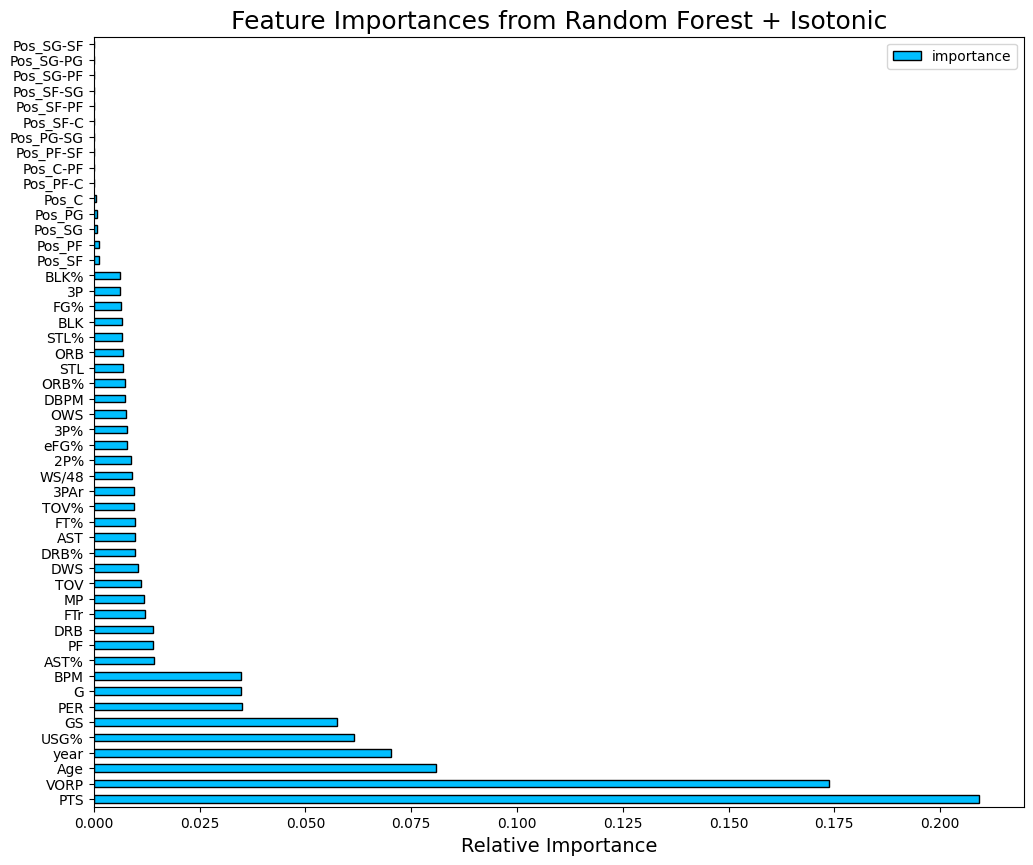

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_rf_best[:50].plot(x = 'feature', y = 'importance',
                             color='deepskyblue',
                             edgecolor = 'k',
                             kind='barh',
                             ax = ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from Random Forest + Isotonic', size = 18);

In [ ]:
y_predicted = rf_best.predict(X_val)
print('r2 score for val data:', r2_score(y_val, y_predicted))

r2 score for val data: 0.6922044919538282


🐦 Получилось немного улучшить скор с помощью подбора параметров RandomizedSearchCV

🦝 Интерпретируем важности признаков с помощью SHAP
https://habr.com/ru/company/ods/blog/599573/

In [ ]:
# Extract the names of the most important features
feature_results_rf_best_sorted = feature_results_rf_best.sort_values(by='importance', ascending=False)
most_important_features = feature_results_rf_best_sorted['feature'][:10]

In [ ]:
X_val_200 = X_val.sample(200)

In [ ]:
import shap
shap.initjs()
rf_best = RandomForestRegressor(n_estimators= 555,
                                  min_samples_split = 2,
                                  min_samples_leaf = 2,
                                  max_depth = 50,
                                  bootstrap = True,
                                  random_state=123)
rf_best.fit(X_train.values, y_train.values)
gb_explainer = shap.KernelExplainer(rf_best.predict, X_val_200)
gb_shap_values = gb_explainer.shap_values(X_val_200)

  0%|          | 0/200 [00:00<?, ?it/s]

🙈 не смогла запустить на все объекты, на моем ноуте это заняло бы больше 10-ти часов.

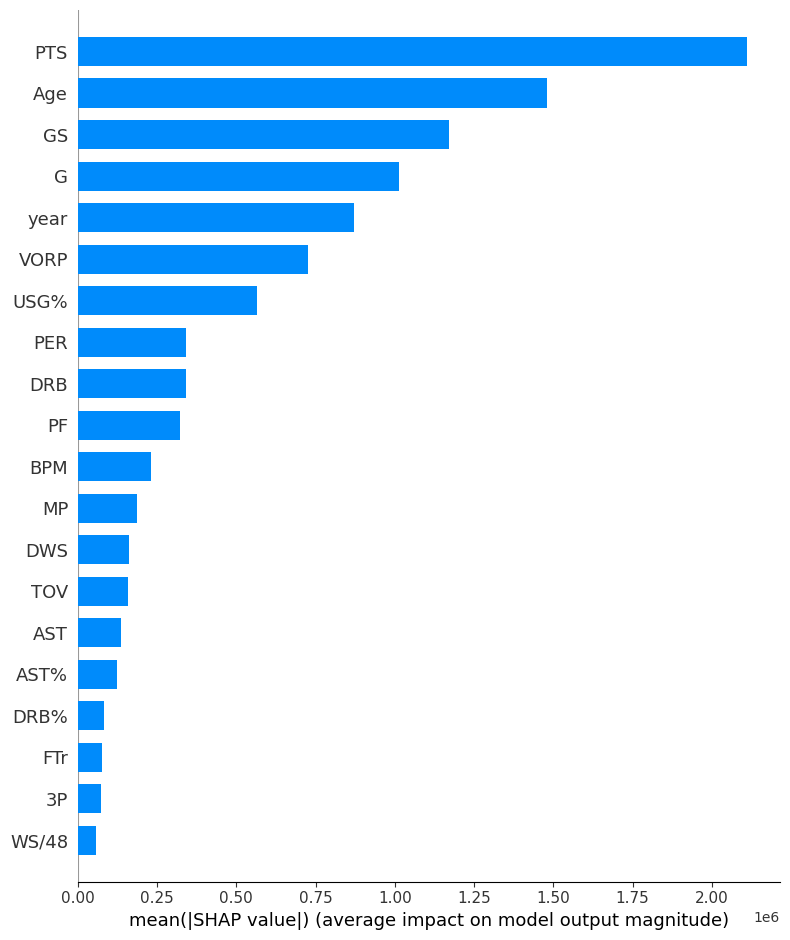

In [ ]:
shap.summary_plot(gb_shap_values, X_val_200, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


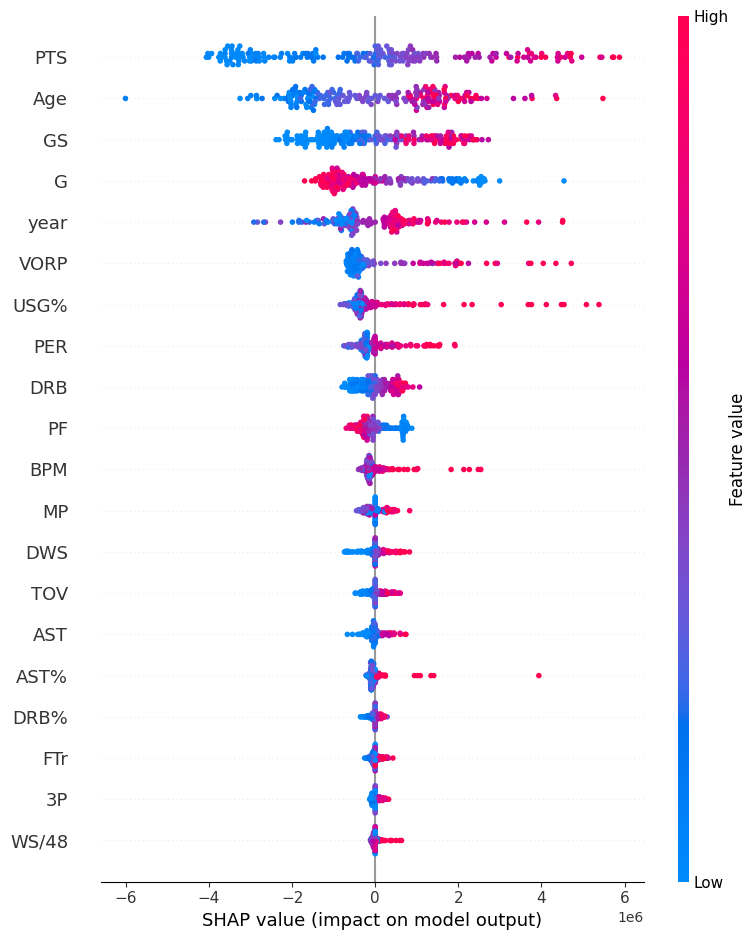

In [ ]:
shap.summary_plot(gb_shap_values, X_val_200)

### 🦆 Интерпретация графика
Сильное влияние на офер имеет очки заработанные за сезон игроком, а также возраст. Мы видим, что чем больше `PTS` (красный цвет), тем большее SHAP value (горизонтальная ось) назначается этому признаку. Большое значение SHAP value, означает, что удаление этого признака (замена его значения на неопределенное) существенно уменьшит предсказанную стоимость.

Можно также заметить на графике, что SHAP values, соответствующие признакам `PER, BPM, WS/48`, имеют положительные значения SHAP values. Значит, что есть много значений объектов, которые увеличивают уровень оферной стоимости игрока для используемой модели, но нет таких значений, которые бы его сильно уменьшали.

🐺 Интерпретируем важности признаков с помощью LIME

In [ ]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train.values,
                                                   mode = 'regression',
                                                   training_labels = y_train.values)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Prediction: 31465346.8053
Actual Value: 7574125.0000


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


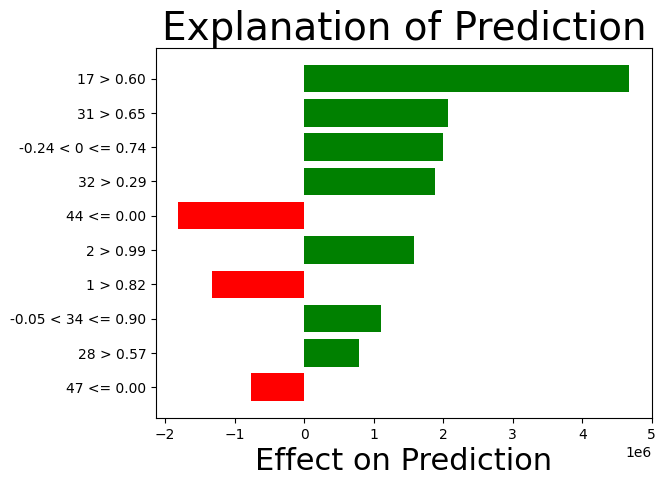

In [ ]:
y_pred = rf_best.predict(X_val.values)
# Find the residuals
residuals = abs(y_pred - y_val)
# Exact the worst and best prediction
wrong = X_val.values[np.argmax(residuals), :]
right = X_val.values[np.argmin(residuals), :]
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong,
                                       predict_fn = rf_best.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
wrong_exp.show_in_notebook(show_predicted_value=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Prediction: 4042207.1055
Actual Value: 4040440.0000


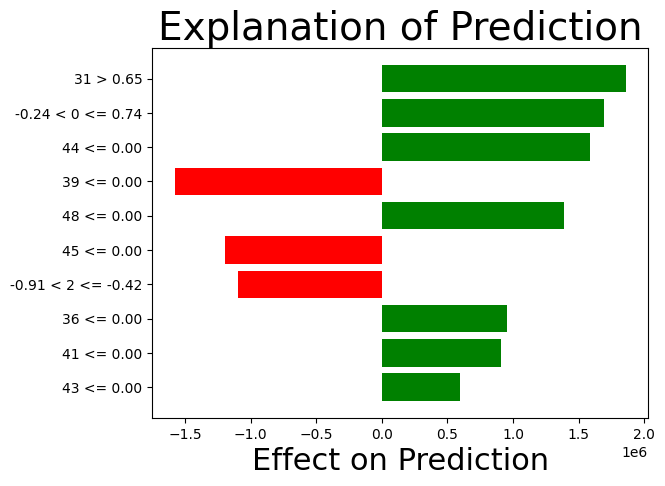

In [ ]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % rf_best.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_val.values[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, rf_best.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
right_exp.show_in_notebook(show_predicted_value=False)

 🐍 Посчитаем разброс и смещение полученной композиции https://habr.com/ru/companies/ods/articles/323890/

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        rf_best, X_train.values, y_train.values, X_val.values, y_val.values, 
        #loss='mse',#
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 1.000
Average bias: 1.000
Average variance: 0.995


🐧 Случайное дерево, дающее лучший скор, сохраняем в pickle

In [ ]:
pickle.dump(rf_best, open('RF.pkl', 'wb'))

🐊 Проверяем сохраненный файл с моделью

In [ ]:
with open('RF.pkl', 'rb') as f:
    pickled_model = pickle.load(f)
result = pickled_model.score(X_val, y_val)
print(result)

0.6922044919538282


# Бустинги

## CatBoost

🐅 Пробуем модель CatBoostRegressor

In [ ]:
pipelineCatBoost = Pipeline([
    ('model_', CatBoostRegressor())
    ])
pipelineCatBoost.fit(X_train, y_train)

y_pred = pipelineCatBoost.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_pred))
print('r2 score for val data:', r2_score(y_val, y_pred))

Learning rate set to 0.04813
0:	learn: 8627442.9397614	total: 72ms	remaining: 1m 11s
1:	learn: 8418476.2961268	total: 79.1ms	remaining: 39.5s
2:	learn: 8256557.8125726	total: 86.1ms	remaining: 28.6s
3:	learn: 8079512.3517029	total: 93.2ms	remaining: 23.2s
4:	learn: 7915300.1748382	total: 100ms	remaining: 20s
5:	learn: 7749581.1119132	total: 107ms	remaining: 17.8s
6:	learn: 7603523.6894655	total: 114ms	remaining: 16.2s
7:	learn: 7451072.2866102	total: 121ms	remaining: 15.1s
8:	learn: 7322939.2494007	total: 128ms	remaining: 14.1s
9:	learn: 7193347.1825976	total: 135ms	remaining: 13.4s
10:	learn: 7087058.6008802	total: 142ms	remaining: 12.8s
11:	learn: 6969332.6092045	total: 150ms	remaining: 12.3s
12:	learn: 6850823.2415222	total: 157ms	remaining: 11.9s
13:	learn: 6752547.1859745	total: 164ms	remaining: 11.5s
14:	learn: 6646767.9254814	total: 171ms	remaining: 11.2s
15:	learn: 6554543.6659224	total: 178ms	remaining: 10.9s
16:	learn: 6472295.8186230	total: 185ms	remaining: 10.7s
17:	learn: 

🦤 Попробуем полиномиальные фичи добавить в модель

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

pipelineCatBoost = Pipeline([
    ('features', PolynomialFeatures(degree = 2)),
    ('model_', CatBoostRegressor())
    ])
pipelineCatBoost.fit(X_train, y_train)

y_predicted_val = pipelineCatBoost.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

Learning rate set to 0.04813
0:	learn: 8651868.2992670	total: 446ms	remaining: 7m 25s
1:	learn: 8467304.6090190	total: 636ms	remaining: 5m 17s
2:	learn: 8297336.8267016	total: 826ms	remaining: 4m 34s
3:	learn: 8143599.4203075	total: 1.01s	remaining: 4m 12s
4:	learn: 7986045.6098785	total: 1.21s	remaining: 4m
5:	learn: 7846913.6300154	total: 1.41s	remaining: 3m 53s
6:	learn: 7713416.4105239	total: 1.61s	remaining: 3m 48s
7:	learn: 7598952.2363858	total: 1.8s	remaining: 3m 43s
8:	learn: 7457937.6952532	total: 1.99s	remaining: 3m 39s
9:	learn: 7338239.5932744	total: 2.18s	remaining: 3m 35s
10:	learn: 7215774.5083336	total: 2.37s	remaining: 3m 33s
11:	learn: 7107938.6512522	total: 2.57s	remaining: 3m 31s
12:	learn: 6995302.2309859	total: 2.77s	remaining: 3m 30s
13:	learn: 6898690.5469699	total: 2.96s	remaining: 3m 28s
14:	learn: 6794298.1868918	total: 3.15s	remaining: 3m 26s
15:	learn: 6716061.8382039	total: 3.34s	remaining: 3m 25s
16:	learn: 6620661.5172850	total: 3.55s	remaining: 3m 25s


🐕 После добавления полиномиальных фичей, скор упал

🦌 Подбираем гиперпараметры для CatBoostRegressor с помощью оптуны

In [ ]:
def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20), 
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param)
    reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_val)
    score = r2_score(y_val, y_pred)
    return score

In [ ]:
from optuna.samplers import TPESampler
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-04-27 17:03:59,073] A new study created in memory with name: no-name-fe9f878b-2855-4160-94ed-8c5044362274
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-04-27 17:04:02,267] Trial 0 finished with value: 0.6701164902192636 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.10468871973657218, 'l2_leaf_reg': 0.12929955348645958, 'colsample_bylevel': 0.079254344961605, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 14, 'subsample': 0.833077106349263}. Best is trial 0 with value: 0.6701164902192636.
suggest_loguniform has been deprecated in v3.0.0. 

Number of completed trials: 100
Best trial:
	Best Score: 0.7195926969694997
	Best Params: 
    loss_function: RMSE
    learning_rate: 0.021809695783635424
    l2_leaf_reg: 0.04062089288222394
    colsample_bylevel: 0.08649343454612272
    depth: 8
    boosting_type: Plain
    bootstrap_type: Bernoulli
    min_data_in_leaf: 17
    one_hot_max_size: 13
    subsample: 0.9264006361359093


In [ ]:
#Re-fit the model with the best hyperparameters
params = trial.params
model = CatBoostRegressor(**params)
pipelineCatBoost = Pipeline([
    ('model_', model)
    ])
pipelineCatBoost.fit(X_train, y_train)
y_pred = pipelineCatBoost.predict(X_val)

print(r2_score(y_val, y_pred))

0:	learn: 8754278.6340330	total: 3.91ms	remaining: 3.9s
1:	learn: 8672930.2087756	total: 10.1ms	remaining: 5.06s
2:	learn: 8589645.6137977	total: 15.8ms	remaining: 5.25s
3:	learn: 8500707.9303867	total: 19.8ms	remaining: 4.92s
4:	learn: 8424790.2716008	total: 24.5ms	remaining: 4.87s
5:	learn: 8342647.8702519	total: 28.6ms	remaining: 4.74s
6:	learn: 8278198.9580232	total: 29.7ms	remaining: 4.22s
7:	learn: 8193951.7445597	total: 33.8ms	remaining: 4.2s
8:	learn: 8101334.6846349	total: 37.8ms	remaining: 4.17s
9:	learn: 8025309.5308968	total: 41.9ms	remaining: 4.14s
10:	learn: 7957339.5972076	total: 47.1ms	remaining: 4.24s
11:	learn: 7875992.6959690	total: 51.9ms	remaining: 4.28s
12:	learn: 7812187.6899527	total: 56.1ms	remaining: 4.26s
13:	learn: 7744322.6014420	total: 60ms	remaining: 4.23s
14:	learn: 7682774.8266810	total: 64.7ms	remaining: 4.25s
15:	learn: 7601170.2778768	total: 69.2ms	remaining: 4.26s
16:	learn: 7543127.2553702	total: 73.8ms	remaining: 4.27s
17:	learn: 7480032.1034903	t

🕊️ Сохраняем модель в файл


In [ ]:
pickle.dump(pipelineCatBoost, open('CatBoost.pkl', 'wb'))

🪿 Отобразим `feature_importances_`

In [ ]:
feature_results_CatBoost = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': pipelineCatBoost[0].feature_importances_})

feature_results_CatBoost = feature_results_CatBoost.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results_CatBoost.head(10)

feature  importance
0     Age    9.743743
1    year    7.648687
2    USG%    7.299842
3      GS    5.648758
4       G    4.530127
5    VORP    4.297906
6     PTS    3.801349
7     TOV    3.157052
8    AST%    3.123061
9     BPM    2.638946

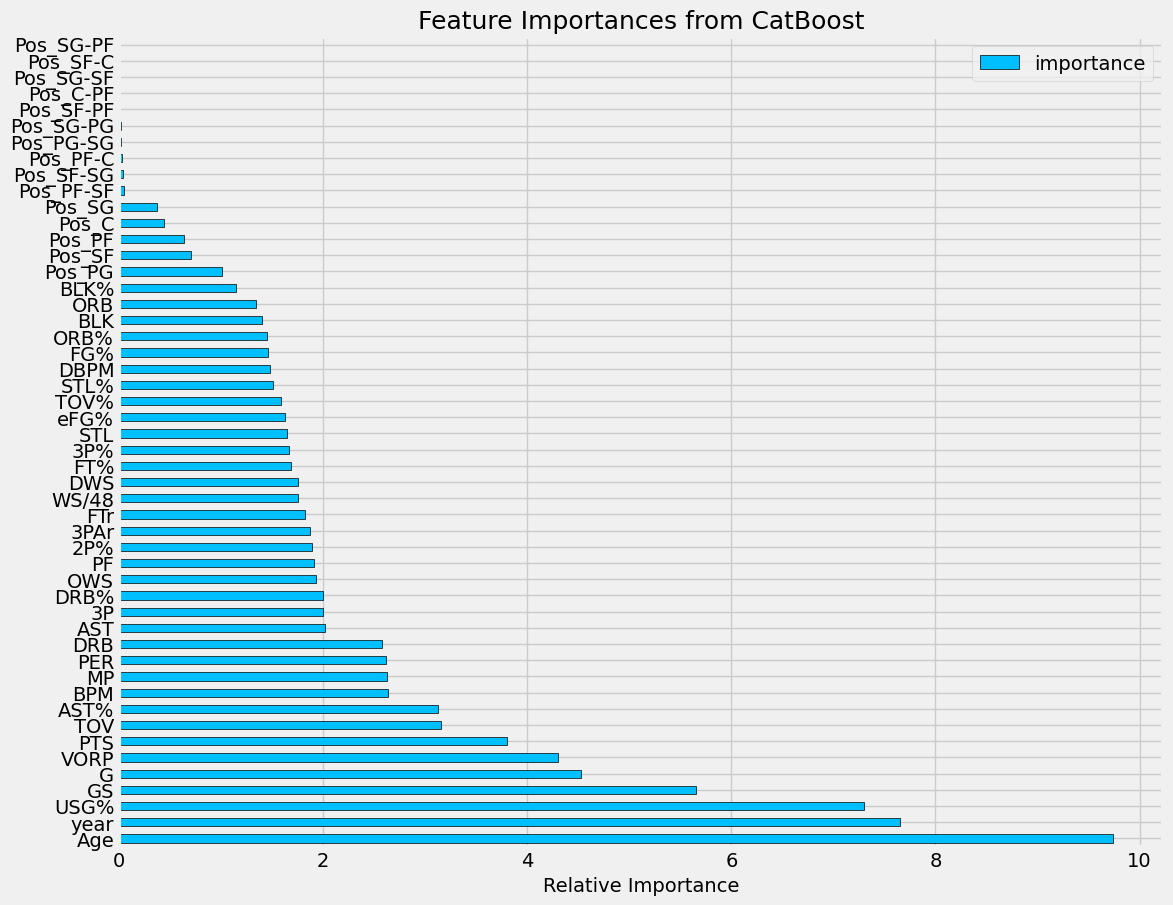

In [ ]:
# Plot the 15 most important features in a horizontal bar chart
plt.style.use('fivethirtyeight');
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_CatBoost.plot(x = 'feature', y = 'importance',
                              color='deepskyblue',
                              edgecolor = 'k',
                              kind='barh',
                              ax=ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from CatBoost', size = 18);

## XGBoost

🐻 Пробуем модель XGBoost

In [ ]:
pipelineXGBoost = Pipeline([
    ('model_', XGBRegressor())
    ])
pipelineXGBoost.fit(X_train, y_train)

y_predicted_val = pipelineXGBoost.predict(X_val)

print('mse for val data:', mean_squared_error(y_val, y_predicted_val))
print('r2 score for val data:', r2_score(y_val, y_predicted_val))

mse for val data: 25375097216162.75
r2 score for val data: 0.6697961204496314


🦌 Подбираем гиперпараметры для XGBoostRegressor с помощью оптуны

In [ ]:
# https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    pipelineXGBoost_optuna = Pipeline([
    ('model_', XGBRegressor(**params))
    ])

    # Fit the model
    pipelineXGBoost_optuna.fit(X_train, y_train)

    # Make predictions
    y_predicted_val = pipelineXGBoost_optuna.predict(X_val)

    # Evaluate predictions
    accuracy = r2_score(y_val, y_predicted_val)
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-04-27 17:14:29,135] A new study created in memory with name: no-name-9b6a813e-d96c-4206-904e-d9f297b43bfa
[I 2023-04-27 17:14:29,744] Trial 0 finished with value: 0.06507232241760663 and parameters: {'max_depth': 2, 'learning_rate': 0.4062722703280001, 'n_estimators': 197, 'min_child_weight': 10, 'gamma': 0.04172617415081921, 'subsample': 0.04221560068892928, 'colsample_bytree': 0.029162873497999443, 'reg_alpha': 0.0001622310916430073, 'reg_lambda': 0.0002383158748771797}. Best is trial 0 with value: 0.06507232241760663.
[I 2023-04-27 17:14:31,614] Trial 1 finished with value: 0.1673295780941323 and parameters: {'max_depth': 3, 'learning_rate': 0.8734981760773158, 'n_estimators': 210, 'min_child_weight': 2, 'gamma': 0.00010012539764145195, 'subsample': 0.5649038833130658, 'colsample_bytree': 0.014795646562319803, 'reg_alpha': 0.4570452255507607, 'reg_lambda': 0.03543576321166526}. Best is trial 1 with value: 0.1673295780941323.
[I 2023-04-27 17:14:32,453] Trial 2 finished with 

CPU times: user 26min 43s, sys: 15.5 s, total: 26min 58s
Wall time: 15min 22s


In [ ]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.7163004900520304
  Params: 
    max_depth: 9
    learning_rate: 0.02040760412842366
    n_estimators: 377
    min_child_weight: 10
    gamma: 0.00047728369447393084
    subsample: 0.6105800050704477
    colsample_bytree: 0.6730712712795865
    reg_alpha: 9.143851413297398e-08
    reg_lambda: 0.21895149117919527


In [ ]:
#Re-fit the model with the best hyperparameters
params = trial.params
model = XGBRegressor(**params)
pipelineXGBoost = Pipeline([
    #('scaler_', MyStandardScaler(continuous_cols)),
    ('model_', model)
    ])
pipelineXGBoost.fit(X_train, y_train)
y_pred = pipelineXGBoost.predict(X_val)

print(r2_score(y_val, y_pred))

0.7163004900520304


🦢 Сохраняем модель в файл

In [ ]:
pickle.dump(pipelineXGBoost, open('XGBoost.pkl', 'wb'))

In [ ]:
with open('XGBoost.pkl', 'rb') as f:
    pipelineXGBoost = pickle.load(f)

🦉 Отобразим `feature_importances_`

In [ ]:
feature_results_XGBoost = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': pipelineXGBoost[0].feature_importances_})
feature_results_XGBoost = feature_results_XGBoost.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_XGBoost.head(10)

feature  importance
0    VORP    0.239650
1     PTS    0.104868
2      GS    0.081002
3    year    0.043973
4     Age    0.039930
5    USG%    0.034592
6     BPM    0.029021
7     PER    0.026792
8       G    0.024875
9     DWS    0.017455

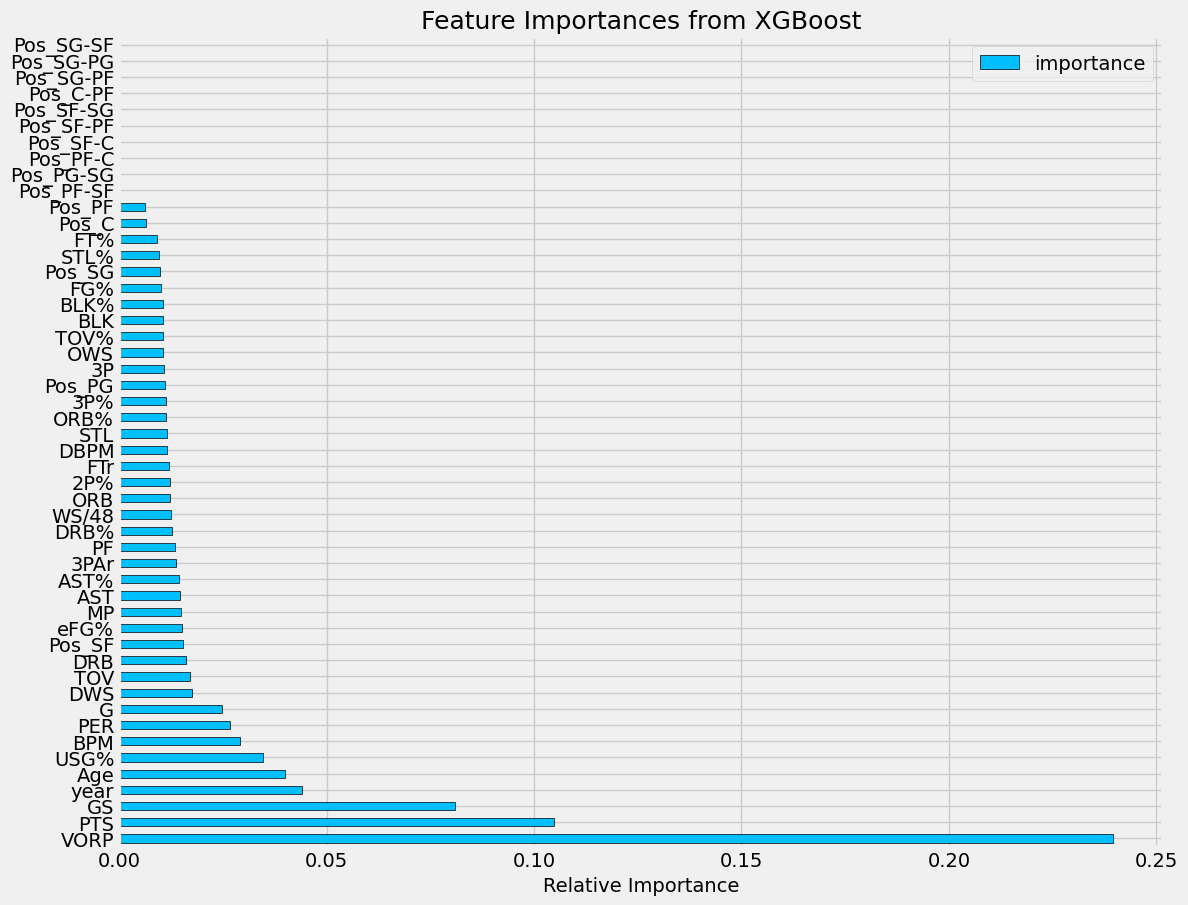

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_XGBoost.plot(x = 'feature', y = 'importance',
                             color='deepskyblue',
                             edgecolor = 'k',
                             kind='barh',
                             ax=ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from XGBoost', size = 18);

## LightGBM

🐢 Пробуем модель LightGBM

In [ ]:
pipe = [
    ('lgbm', LGBMRegressor())
]
lgbm_pipeline = Pipeline(pipe)

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)

print(r2_score(y_val, y_pred))

0.7001196329588747


🦂 Подбираем гиперпараметры для LGBMRegressor с помощью оптуны

In [ ]:
def objective(trial):
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    y_pred = model.predict(X_val)
    accuracy = r2_score(y_val, y_pred)
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-27 17:43:50,075] A new study created in memory with name: no-name-b1e49ad0-4530-47e6-b5ea-fc8a4ac0d2d2
[I 2023-04-27 17:43:55,723] Trial 0 finished with value: 0.6999334830984838 and parameters: {'reg_alpha': 1.0147505666697136, 'reg_lambda': 0.007086641669459015, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 299, 'min_child_samples': 40, 'min_data_per_groups': 91}. Best is trial 0 with value: 0.6999334830984838.
[I 2023-04-27 17:43:57,013] Trial 1 finished with value: 0.6976562978306394 and parameters: {'reg_alpha': 0.8227963152198352, 'reg_lambda': 0.57054592418885, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 951, 'min_child_samples': 121, 'min_data_per_groups': 58}. Best is trial 0 with value: 0.6999334830984838.
[I 2023-04-27 17:44:00,695] Trial 2 finished with value: 0.6790923189867748 and parameters: {'reg_alpha': 0.0016659018555936743, 'reg_lambda': 0.0603765915680

Number of finished trials: 200
Best trial: {'reg_alpha': 0.5415544816698243, 'reg_lambda': 0.04231072892297279, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 127, 'min_child_samples': 10, 'min_data_per_groups': 15}


In [ ]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.7182982172701392
  Params: 
    reg_alpha: 0.5415544816698243
    reg_lambda: 0.04231072892297279
    colsample_bytree: 0.8
    subsample: 1.0
    learning_rate: 0.008
    max_depth: 10
    num_leaves: 127
    min_child_samples: 10
    min_data_per_groups: 15


In [ ]:
#Re-fit the model with the best hyperparameters
params = {'reg_alpha': 0.5415544816698243, 'reg_lambda': 0.04231072892297279, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 127, 'min_child_samples': 10}
model = LGBMRegressor(**params)
pipelineLGBM = Pipeline([
    ('model_', model)
    ])
pipelineLGBM.fit(X_train, y_train)
y_pred = pipelineLGBM.predict(X_val)

print(r2_score(y_val, y_pred))

0.5236588480723707


🐞 Сохраняем модель в файл

In [ ]:
pickle.dump(pipelineLGBM, open('LGBM.pkl', 'wb'))

🦚 Отобразим `feature_importances_`

In [ ]:
feature_results_LGBM = pd.DataFrame({'feature': list(X_train.columns),
                                'importance': pipelineLGBM[0].feature_importances_})
feature_results_LGBM = feature_results_LGBM.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_LGBM.head(10)

feature  importance
0       G         917
1     Age         876
2    year         686
3     PTS         658
4    USG%         620
5     DRB         503
6      GS         473
7      MP         417
8     DWS         374
9      PF         364

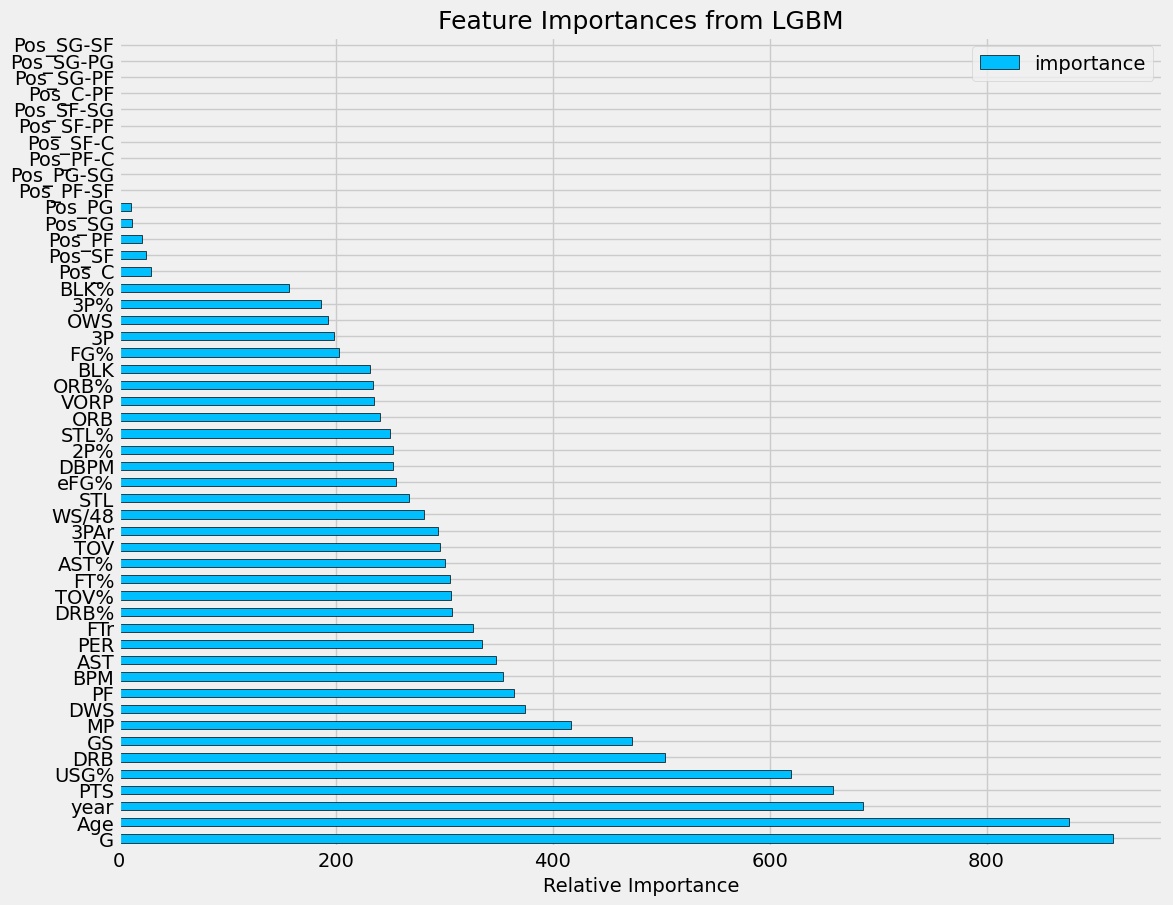

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
feature_results_LGBM.plot(x = 'feature', y = 'importance',
                             color='deepskyblue',
                             edgecolor = 'k',
                             kind='barh',
                             ax=ax);
plt.xlabel('Relative Importance', size = 14); plt.ylabel('');
plt.title('Feature Importances from LGBM', size = 18);

# Стекинг

🐧Пробуем стекинг XGBoost + LinearRegression

In [ ]:
with open('XGBoost.pkl', 'rb') as f:
    xgboost_pipeline = pickle.load(f)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
estimators = [
    ('xgboost', xgboost_pipeline)
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(r2_score(y_val, y_pred))

0.7173278115872532


In [ ]:
pickle.dump(clf, open('XGBoost-LR.pkl', 'wb'))

🦖 Создадим таблицу, в которой для сохраненных pickle'ом регрессоров в соответствующих столбцах будут отранжированные по убыванию `feature_importances_` для конкретной модели.

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [ ]:
with open('LGBM.pkl', 'rb') as f:
    pipelineLGBM = pickle.load(f)
with open('CatBoost.pkl', 'rb') as f:
    pipelineCatBoost = pickle.load(f)
with open('RF.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('XGBoost.pkl', 'rb') as f:
    pipelineXGBoost = pickle.load(f)

In [ ]:
feature_results_XGBoost = pd.DataFrame({'feature': list(X_train.columns),
                                        'importance': pipelineXGBoost[0].feature_importances_,
                                        'model': 'xgboost'})
feature_results_CatBoost = pd.DataFrame({'feature': list(X_train.columns),
                                         'importance': pipelineCatBoost[0].feature_importances_ * 0.01,
                                         'model': 'catboost'})
feature_results_LGBM = pd.DataFrame({'feature': list(X_train.columns),
                                   'importance': pipelineLGBM[0].feature_importances_* 0.0001,
                                   'model': 'LGBM'})
feature_results_rf = pd.DataFrame({'feature': list(X_train.columns),
                                   'importance': rf.feature_importances_,
                                   'model': 'rf'})

In [ ]:
feature_results_full = pd.concat([feature_results_rf,
                                  feature_results_LGBM,
                                  feature_results_CatBoost,
                                  feature_results_XGBoost
                                 ]).reset_index()
feature_results_full = feature_results_full.sort_values(by='importance', ascending=False)
feature_results_full.sample(5)

index    feature  importance     model
33      33      WS/48    0.008991        rf
144     44  Pos_SF-PF    0.000095  catboost
17      17        PTS    0.209282        rf
133     33      WS/48    0.017578  catboost
74      24        DWS    0.037400      LGBM

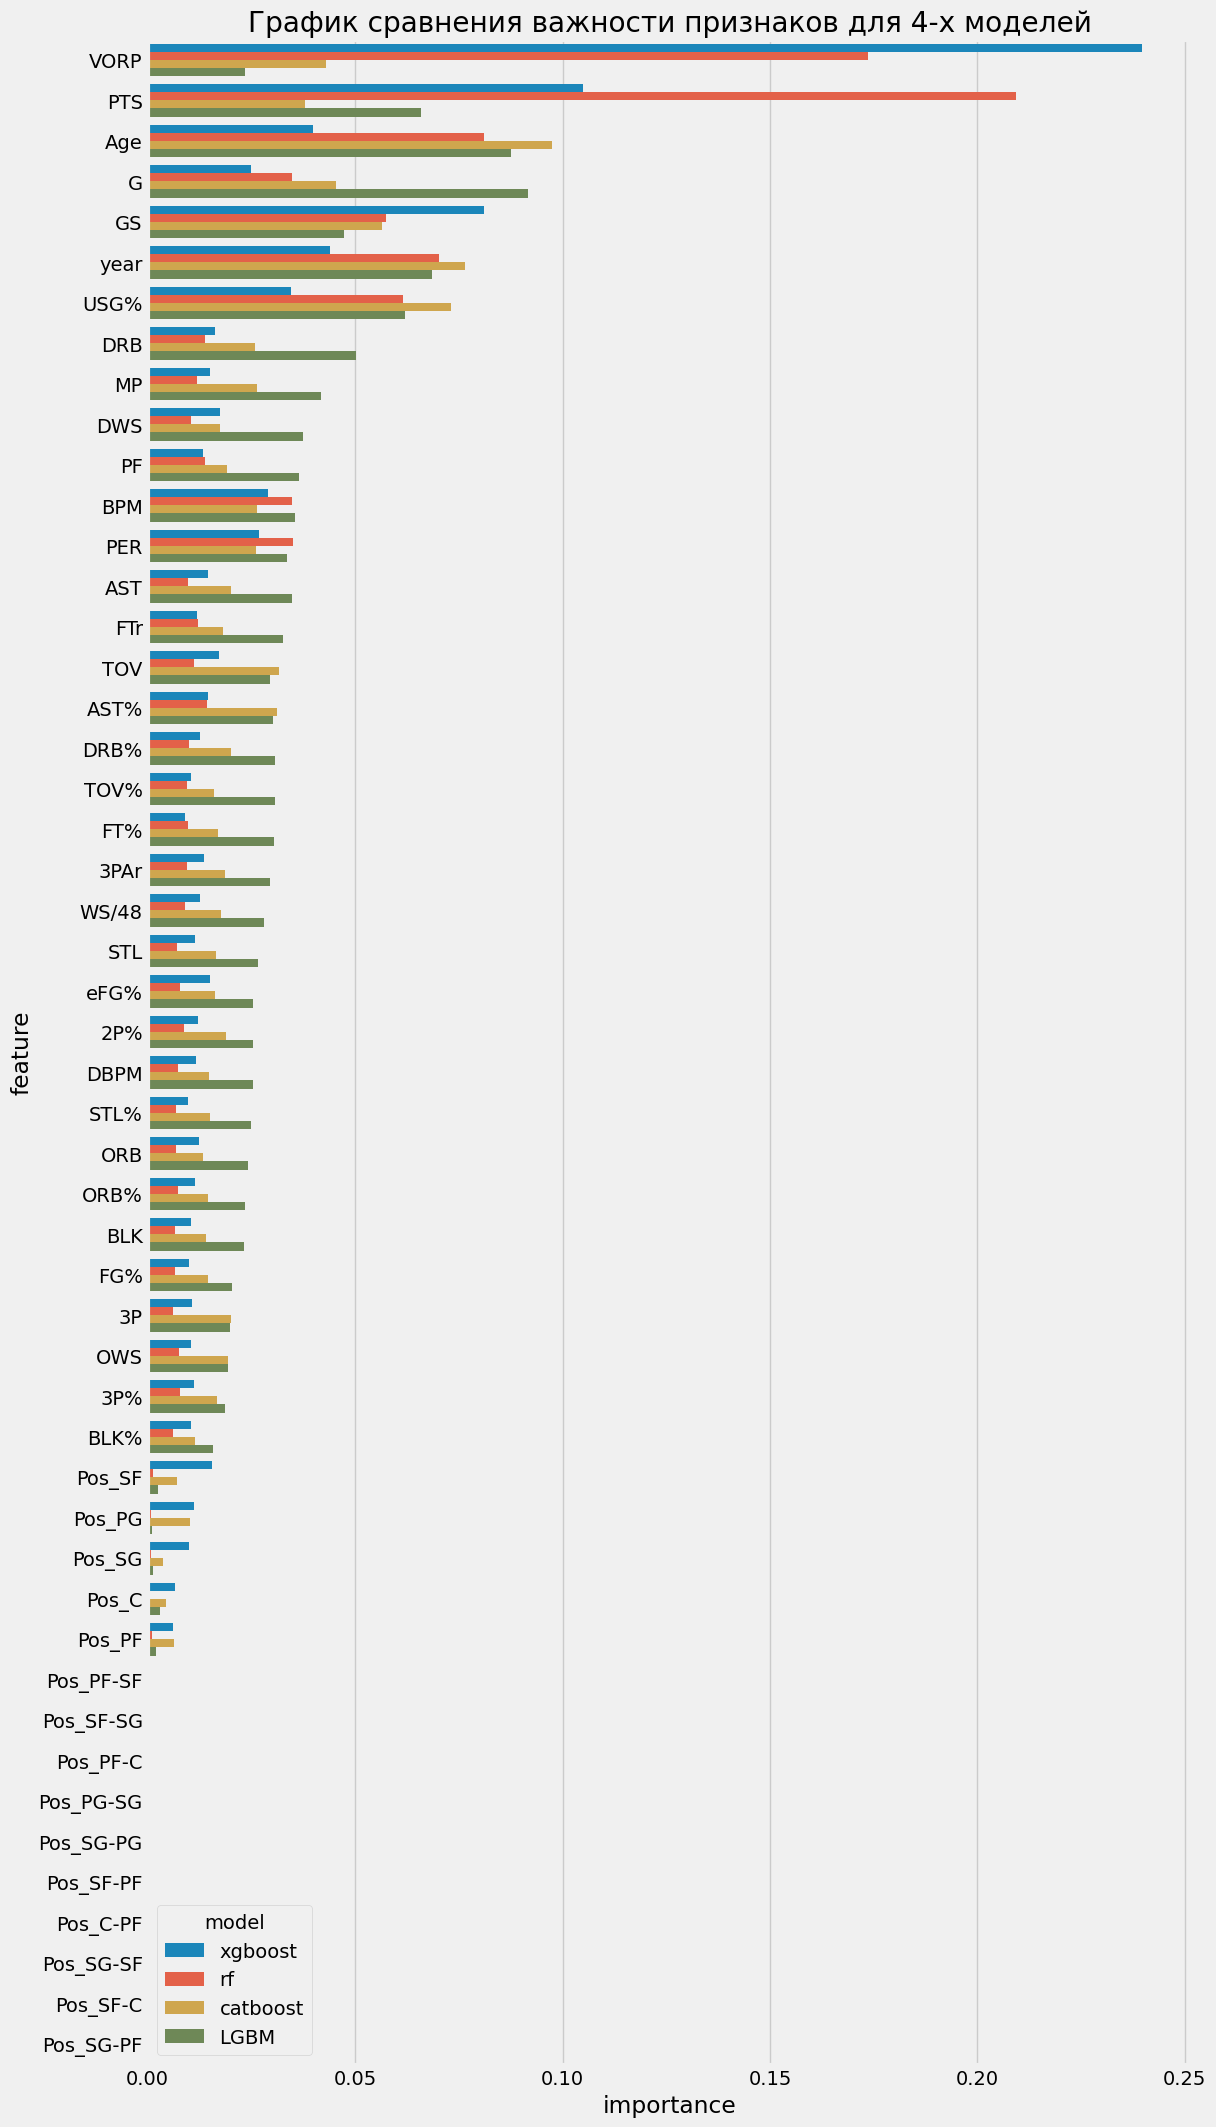

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
sns.barplot(data = feature_results_full,
            y = 'feature',
            x = 'importance',
            hue = 'model',
            ax = ax).set_title('График сравнения важности признаков для 4-х моделей');

🐸 Далее для отбора признаков воспользуемся статистическими тестами. Попробуем отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов применим (отдельно) `f_regression` и `mutual_info_classif`

In [ ]:
removed_features = ['Pos_SG-PF', 'Pos_SF-C', 'Pos_SG-SF']

In [ ]:
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=20)
selector.fit(X_train, y_train)
selected_feature_names = X_train.columns[selector.get_support()]
check_f_classif = any(item in selected_feature_names for item in removed_features)
print('test for f_regression:', check_f_classif)

test for f_regression: False


In [ ]:
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(X_train, y_train)
selected_feature_names = X_train.columns[selector.get_support()]
check_mutual_info_classif = any(item in selected_feature_names for item in removed_features)
print('test for mutual_info_classif:', check_mutual_info_classif)

test for mutual_info_classif: False


In [ ]:
🐥 Да, оба теста показали, что по графику выбранные вручную 3 признака можно удалить.